# Dependencies loading 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings('ignore')




# Data loading

In [2]:
base_url = "https://raw.githubusercontent.com/Niyetali/FIFA-Rating-Prediction/main/output"

# Importing datasets
X_train = pd.read_csv(f"{base_url}/X_train_fe.csv", sep=",", encoding="utf-8", on_bad_lines='skip', engine="python")
X_test = pd.read_csv(f"{base_url}/X_test_fe.csv", sep=",", encoding="utf-8", on_bad_lines='skip', engine="python")
y_train = pd.read_csv(f"{base_url}/y_train.csv", sep=",", encoding="utf-8", on_bad_lines='skip', engine="python")
y_test = pd.read_csv(f"{base_url}/y_test.csv", sep=",", encoding="utf-8", on_bad_lines='skip', engine="python")

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)



(14100, 42) (3525, 42)
(14100, 1) (3525, 1)


In [3]:
print(X_train.dtypes)


Name                         object
Age                           int64
Nationality                 float64
Potential                     int64
Club                        float64
International Reputation    float64
Weak Foot                   float64
Skill Moves                 float64
Body_Type                     int64
Attacking_Work_Rate           int64
Defensive_Work_Rate           int64
CB                            int64
CDM                           int64
CF                            int64
CM                            int64
GK                            int64
LAM                           int64
LB                            int64
LCB                           int64
LCM                           int64
LDM                           int64
LF                            int64
LM                            int64
LS                            int64
LW                            int64
LWB                           int64
RAM                           int64
RB                          

# AdaBoost Model

Before beginning training our model, it is imprtant to note that we will drop the "Name" for the purpose of evaluating our AdaBoost, as this feature does not add much signinficant value to "Overall" as mentioned in Feature Engineering. Is is however, kept in our dataset as an ID.

In [4]:
X_train = X_train.drop(columns=["Name"])
X_test = X_test.drop(columns=["Name"])

### Simple base model

In [5]:
# Initializing simple AdaBoost regressor
adaboost_regressor = AdaBoostRegressor(random_state=42)

# Training AdaBoost regressor 
adaboost_regressor.fit(X_train, y_train)

# Predictions on the test set
y_pred = adaboost_regressor.predict(X_test)



### Model Evaluation

In [6]:
# Mean Squarred Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# R2 score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

# Adjusted R2 
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print(f"Adjusted R² Score: {r2}")

# RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Mean Absolute Percentage Error
y_test = y_test.squeeze()  # Converting DataFrame to Series
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape}")

# Symmetric MAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)
print(f"Symmetric Mean Absolute Percentage Error: {smape}")



Mean Squared Error: 4.07614001658842
R² Score: 0.9362073686909488
Adjusted R² Score: 0.9362073686909488
Root Mean Squared Error: 2.0189452733019833
Mean Absolute Error: 1.6132284265326011
Mean Absolute Percentage Error: 2.581823755911327
Symmetric Mean Absolute Percentage Error: 2.575482037491339


The above metrics derived from the AdaBoost Regressor, which we implemented without any hyperparameter tuning to establish a baseline for its performance, delivered pretty decent results, namely: 
- **R² Score** : The model explains 93.62% of the variance in the target variable.
- **Mean Squared Error (MSE)**: The average squared difference between actual and predicted values is around 4.07.
- **Root Mean Squared Error (RMSE)**: The model's typical error in the same units as the target variable is 2.018.
- **Mean Absolute Error (MAE)**: The average prediction error is approximately 1.613
- **Mean Absolute Percentage Error (MAPE)**: The predictions deviate by only ~2.58% from actual values on average.
- **Symmetric Mean Absolute Percentage Error (SMAPE)**: Shows similar results while accounting for the relative scale of predictions and actual values.

The model demonstrates excellent predictive power, as indicated by the high R² score and low error metrics.
The small difference between MAE and RMSE suggests minimal influence of outliers on model performance.

Further in the next steps, we will examine how the model would perform with hyperparameters.


### Scatter Plot

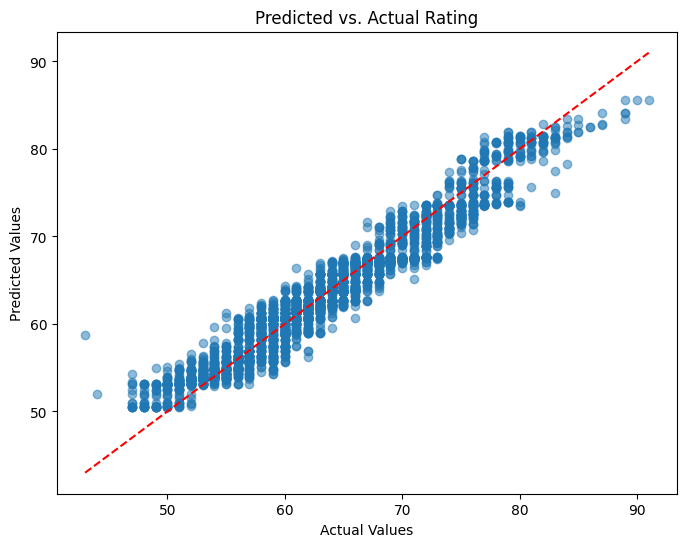

In [7]:
# actual vs. predicted values of "Overall"
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Rating')
plt.show()


As we can see, most points are close to the diagonal, indicating that the model predictions are highly accurate. Nevertheless, there is some spread, especially at the lower and higher ends of the scale. This could indicate slight underprediction (overprediction) for lower (higher) actual values.

### Residual Plot

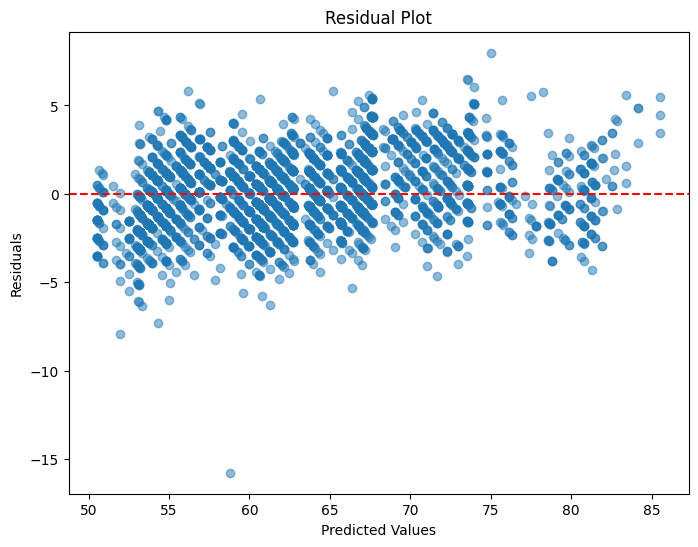

In [8]:
# Converting test set to a 1D Series
y_test = y_test.squeeze()  # Converts a single-column DataFrame to a Series

# residuals
residuals = y_test - y_pred

# Plot 
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


The residuals do not exhibit a clear trend or pattern (e.g., funnel shape or curvature), which suggests the model assumptions (e.g., linearity and independence of errors) are likely valid. The spread of residuals appears roughly constant across predicted values, meaning the model's performance is consistent across the range of predictions. However, the presence of outliers suggests that there may be a few cases where the model struggles, likely due to noisy data, insufficient features, or inherent complexity.

### Distribution of Residuals

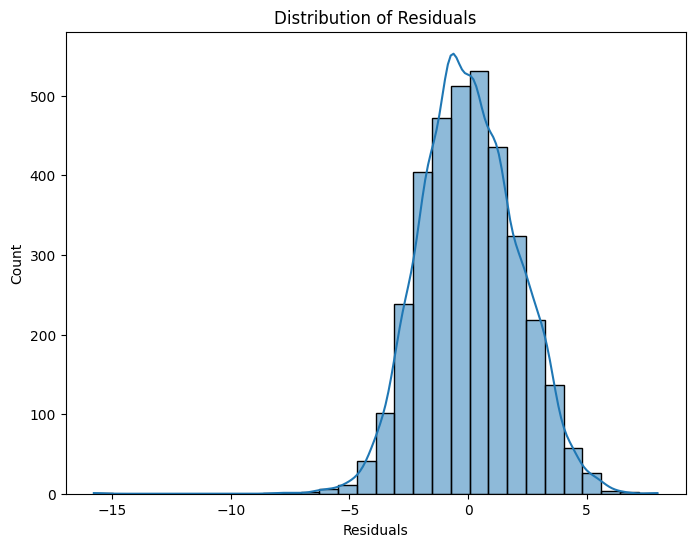

In [9]:

# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()


The residuals roughly follow a bell-shaped curve, resembling a normal distribution. This is desirable as it aligns with the assumption of normally distributed errors. A small number of residuals fall outside the range of −5 to +5, indicating some outliers where the model predictions deviate significantly from the actual values.

### Q-Q Plot of Residuals 

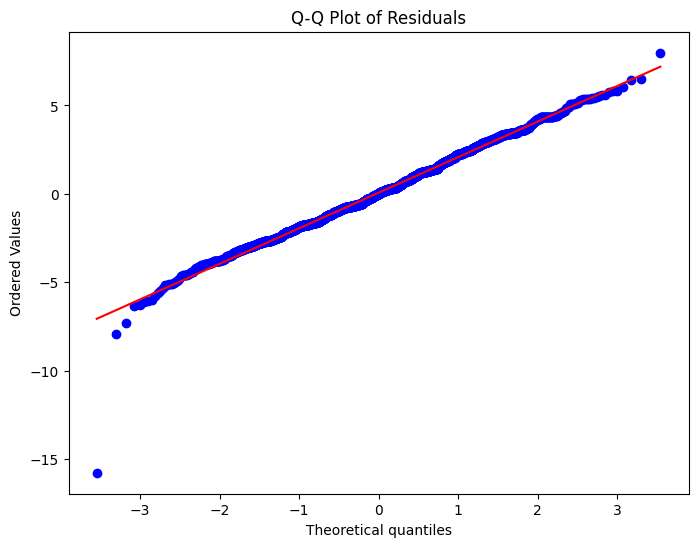

In [10]:
# Q-Q plot for residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


The **Q-Q (quantile-quantile) plot** compares the quantiles of your residuals to the quantiles of a standard normal distribution. We can observe that most of the points lie close to the red diagonal line, indicating that the residuals roughly follow a normal distribution. The suggestion regarding outliers made earlier can be confirmed with slight deviation at the extremes (both lower and upper tails), as the points deviate from the diagonal line.

## Hyperparameters Tuning

We now proceed to check whether our model improves with Hyperparameters tuned

In [11]:
# Our base estimator (weak learner)
base_estimator = DecisionTreeRegressor(max_depth=2, min_samples_leaf=5)

# Initializing with base estimator AdaBoostRegressor
adaboost_regressor = AdaBoostRegressor(
    estimator=base_estimator,
    random_state=42
)

# Hyperparameters grid
param_distributions = {
    'n_estimators': [50, 100, 200, 300, 500],  # Number of estimators
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],  # Learning rates
    'loss': ['linear', 'square', 'exponential'],  # Loss functions
    'estimator__max_depth': [1, 2, 3, 5, 10]  # Depth of the weak learners
}

# Applying RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=adaboost_regressor,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    scoring='neg_mean_squared_error',  # negative is used since MSE is loss metric but we want to show higher scores)
    cv=5,  # 5-fold cross-validation
    random_state=42,
    verbose=2,
    n_jobs=-1 
)

# Training our model 
random_search.fit(X_train, y_train)

# Best hyperparameters and best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Prediction
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was 

[CV] END estimator__max_depth=10, learning_rate=0.5, loss=linear, n_estimators=200; total time=  37.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.5, loss=linear, n_estimators=200; total time=  37.5s
[CV] END estimator__max_depth=10, learning_rate=0.5, loss=linear, n_estimators=200; total time=  38.0s
[CV] END estimator__max_depth=10, learning_rate=0.5, loss=linear, n_estimators=200; total time=  38.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=square, n_estimators=500; total time=  16.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=square, n_estimators=500; total time=  24.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=square, n_estimators=500; total time=  25.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.5, loss=linear, n_estimators=200; total time=  38.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=square, n_estimators=500; total time=  26.6s
[CV] END estimator__max_depth=2, learning_rate=0.05, loss=exponential, n_estimators=200; total time=  17.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=square, n_estimators=500; total time=  26.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.05, loss=exponential, n_estimators=200; total time=  16.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.1, loss=linear, n_estimators=50; total time=   3.1s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.05, loss=exponential, n_estimators=200; total time=  16.7s
[CV] END estimator__max_depth=2, learning_rate=0.05, loss=exponential, n_estimators=200; total time=  16.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.1, loss=linear, n_estimators=50; total time=   2.9s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.1, loss=linear, n_estimators=50; total time=   2.6s
[CV] END estimator__max_depth=1, learning_rate=0.1, loss=linear, n_estimators=50; total time=   2.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.1, loss=linear, n_estimators=50; total time=   2.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.05, loss=exponential, n_estimators=200; total time=  16.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.5, loss=exponential, n_estimators=50; total time=   9.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.5, loss=exponential, n_estimators=50; total time=   9.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.5, loss=exponential, n_estimators=50; total time=   9.1s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.5, loss=exponential, n_estimators=50; total time=   9.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.5, loss=exponential, n_estimators=50; total time=  10.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=1.0, loss=square, n_estimators=200; total time=  12.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=1.0, loss=square, n_estimators=200; total time=  12.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=1.0, loss=square, n_estimators=200; total time=  11.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.5, loss=exponential, n_estimators=50; total time=   6.1s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=1.0, loss=square, n_estimators=200; total time=  10.9s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.5, loss=exponential, n_estimators=50; total time=   6.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=1.0, loss=square, n_estimators=200; total time=  10.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.5, loss=exponential, n_estimators=50; total time=   6.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.5, loss=exponential, n_estimators=50; total time=   6.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.5, loss=exponential, n_estimators=50; total time=   6.1s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=exponential, n_estimators=200; total time=  32.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=exponential, n_estimators=200; total time=  32.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=exponential, n_estimators=200; total time=  32.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=exponential, n_estimators=200; total time=  33.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=2.0, loss=exponential, n_estimators=300; total time=  20.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=2.0, loss=exponential, n_estimators=300; total time=  20.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=2.0, loss=exponential, n_estimators=300; total time=  20.1s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=exponential, n_estimators=200; total time=  30.9s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=2.0, loss=exponential, n_estimators=300; total time=  22.1s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=2.0, loss=exponential, n_estimators=300; total time=  21.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.05, loss=exponential, n_estimators=200; total time=  26.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.05, loss=exponential, n_estimators=200; total time=  26.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.1, loss=exponential, n_estimators=100; total time=   7.9s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.05, loss=exponential, n_estimators=200; total time=  26.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.05, loss=exponential, n_estimators=200; total time=  26.2s
[CV] END estimator__max_depth=2, learning_rate=0.1, loss=exponential, n_estimators=100; total time=   7.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.05, loss=exponential, n_estimators=200; total time=  27.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.1, loss=exponential, n_estimators=100; total time=   8.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.1, loss=exponential, n_estimators=100; total time=   8.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.1, loss=exponential, n_estimators=100; total time=   8.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=1.0, loss=exponential, n_estimators=50; total time=   8.1s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=1.0, loss=exponential, n_estimators=50; total time=   7.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=1.0, loss=exponential, n_estimators=50; total time=   7.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=1.0, loss=exponential, n_estimators=50; total time=   7.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=50; total time=   2.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=50; total time=   3.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=50; total time=   3.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=50; total time=   2.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=50; total time=   2.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=1.0, loss=exponential, n_estimators=50; total time=   8.3s
[CV] END estimator__max_depth=2, learning_rate=0.5, loss=square, n_estimators=50; total time=   3.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.5, loss=square, n_estimators=50; total time=   3.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.5, loss=square, n_estimators=50; total time=   3.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.5, loss=square, n_estimators=50; total time=   4.6s
[CV] END estimator__max_depth=2, learning_rate=0.5, loss=square, n_estimators=50; total time=   4.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.5, loss=linear, n_estimators=100; total time=  10.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.5, loss=linear, n_estimators=100; total time=  10.1s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.5, loss=linear, n_estimators=100; total time=   9.0s
[CV] END estimator__max_depth=5, learning_rate=0.5, loss=linear, n_estimators=100; total time=   9.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.5, loss=linear, n_estimators=100; total time=  10.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.1, loss=linear, n_estimators=500; total time=  32.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.1, loss=linear, n_estimators=500; total time=  32.1s
[CV] END estimator__max_depth=2, learning_rate=0.1, loss=linear, n_estimators=500; total time=  32.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.5, loss=square, n_estimators=100; total time=   8.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.5, loss=square, n_estimators=100; total time=   8.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.1, loss=linear, n_estimators=500; total time=  33.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.5, loss=square, n_estimators=100; total time=   8.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.5, loss=square, n_estimators=100; total time=   9.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.5, loss=square, n_estimators=100; total time=  10.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.5, loss=exponential, n_estimators=50; total time=   5.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.5, loss=exponential, n_estimators=50; total time=   5.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.5, loss=exponential, n_estimators=50; total time=   5.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.5, loss=exponential, n_estimators=50; total time=   5.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.5, loss=exponential, n_estimators=50; total time=   5.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=100; total time=   8.1s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=100; total time=   7.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=100; total time=   7.1s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=100; total time=   5.9s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=100; total time=   5.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.1, loss=linear, n_estimators=500; total time=  44.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.1, loss=square, n_estimators=500; total time=  21.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.1, loss=square, n_estimators=500; total time=  21.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.1, loss=square, n_estimators=500; total time=  21.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.1, loss=square, n_estimators=500; total time=  21.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=300; total time=  12.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=300; total time=  12.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=300; total time=  12.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.1, loss=square, n_estimators=500; total time=  21.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=300; total time=  12.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=300; total time=  12.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=300; total time=  11.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=300; total time=  11.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=300; total time=  11.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=300; total time=  11.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=300; total time=  10.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=1.0, loss=linear, n_estimators=300; total time=  35.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=1.0, loss=linear, n_estimators=300; total time=  35.1s
[CV] END estimator__max_depth=10, learning_rate=1.0, loss=linear, n_estimators=300; total time=  34.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=1.0, loss=linear, n_estimators=300; total time=  35.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.01, loss=square, n_estimators=500; total time=  23.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.01, loss=square, n_estimators=500; total time=  23.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.01, loss=square, n_estimators=500; total time=  23.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=1.0, loss=linear, n_estimators=300; total time=  39.9s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.05, loss=square, n_estimators=300; total time=  18.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.01, loss=square, n_estimators=500; total time=  24.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=0.01, loss=square, n_estimators=500; total time=  24.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.05, loss=square, n_estimators=300; total time=  19.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.05, loss=square, n_estimators=300; total time=  18.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.05, loss=square, n_estimators=300; total time=  18.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.05, loss=square, n_estimators=300; total time=  18.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=1.0, loss=linear, n_estimators=500; total time=  58.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=1.0, loss=linear, n_estimators=500; total time=  57.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=1.0, loss=linear, n_estimators=500; total time=  56.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=1.0, loss=linear, n_estimators=500; total time=  57.9s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=100; total time=  14.4s
[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=100; total time=  14.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=100; total time=  14.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.05, loss=linear, n_estimators=100; total time=   9.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=100; total time=  14.6s
[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=100; total time=  14.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.05, loss=linear, n_estimators=100; total time=   9.9s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.05, loss=linear, n_estimators=100; total time=  10.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.05, loss=linear, n_estimators=100; total time=  10.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=0.05, loss=linear, n_estimators=100; total time=  10.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=1.0, loss=linear, n_estimators=500; total time=  56.9s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.5, loss=linear, n_estimators=200; total time=  11.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.5, loss=linear, n_estimators=200; total time=  11.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.1, loss=linear, n_estimators=50; total time=   4.1s
[CV] END estimator__max_depth=2, learning_rate=0.5, loss=linear, n_estimators=200; total time=   8.9s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.1, loss=linear, n_estimators=50; total time=   3.9s
[CV] END estimator__max_depth=3, learning_rate=0.1, loss=linear, n_estimators=50; total time=   3.9s
[CV] END estimator__max_depth=2, learning_rate=0.5, loss=linear, n_estimators=200; total time=  11.9s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.5, loss=linear, n_estimators=200; total time=  12.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.1, loss=linear, n_estimators=50; total time=   5.2s
[CV] END estimator__max_depth=3, learning_rate=0.1, loss=linear, n_estimators=50; total time=   5.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=1.0, loss=square, n_estimators=200; total time=  13.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=1.0, loss=square, n_estimators=200; total time=  12.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=1.0, loss=square, n_estimators=200; total time=  12.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=1.0, loss=square, n_estimators=200; total time=  12.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=1.0, loss=square, n_estimators=200; total time=  12.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=1.0, loss=linear, n_estimators=500; total time=  54.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=1.0, loss=linear, n_estimators=500; total time=  55.1s
[CV] END estimator__max_depth=5, learning_rate=1.0, loss=linear, n_estimators=500; total time=  55.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=1.0, loss=linear, n_estimators=500; total time=  55.9s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=1.0, loss=square, n_estimators=300; total time=  27.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=1.0, loss=square, n_estimators=300; total time=  28.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=1.0, loss=square, n_estimators=300; total time=  30.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=1.0, loss=linear, n_estimators=500; total time=  50.0s
[CV] END estimator__max_depth=2, learning_rate=0.05, loss=exponential, n_estimators=100; total time=   8.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.05, loss=exponential, n_estimators=100; total time=   9.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.05, loss=exponential, n_estimators=100; total time=   9.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=1.0, loss=square, n_estimators=300; total time=  33.1s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=1.0, loss=square, n_estimators=300; total time=  33.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=50; total time=   3.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=50; total time=   3.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=0.05, loss=exponential, n_estimators=100; total time=  10.1s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=50; total time=   3.3s
[CV] END estimator__max_depth=2, learning_rate=0.05, loss=exponential, n_estimators=100; total time=  10.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=50; total time=   3.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=50; total time=   3.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=2.0, loss=square, n_estimators=500; total time=  28.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=2.0, loss=square, n_estimators=500; total time=  29.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=2.0, loss=square, n_estimators=500; total time=  29.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=2.0, loss=square, n_estimators=500; total time=  35.9s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=50; total time=  11.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=50; total time=  10.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=50; total time=   9.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=50; total time=  11.1s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=2.0, loss=square, n_estimators=500; total time=  26.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=50; total time=  12.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=linear, n_estimators=200; total time=  37.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=linear, n_estimators=200; total time=  41.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=linear, n_estimators=200; total time=  41.0s
[CV] END estimator__max_depth=10, learning_rate=2.0, loss=linear, n_estimators=200; total time=  40.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=200; total time=   9.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=200; total time=   8.6s
[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=200; total time=   8.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=200; total time=   7.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=exponential, n_estimators=50; total time=   6.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=200; total time=   7.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=linear, n_estimators=200; total time=  31.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=exponential, n_estimators=50; total time=   6.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=exponential, n_estimators=50; total time=   6.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=exponential, n_estimators=50; total time=   6.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=square, n_estimators=100; total time=   4.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=exponential, n_estimators=50; total time=   7.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=square, n_estimators=100; total time=   4.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=square, n_estimators=100; total time=   5.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=square, n_estimators=100; total time=   4.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=2.0, loss=square, n_estimators=100; total time=   4.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=1.0, loss=linear, n_estimators=300; total time=   8.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=1.0, loss=linear, n_estimators=300; total time=  15.9s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=1.0, loss=linear, n_estimators=300; total time=  15.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=1.0, loss=linear, n_estimators=300; total time=  15.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=2, learning_rate=1.0, loss=linear, n_estimators=300; total time=  15.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=200; total time=   8.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=200; total time=   8.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=200; total time=   8.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.5, loss=linear, n_estimators=50; total time=   4.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.5, loss=linear, n_estimators=50; total time=   4.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=200; total time=   8.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=1.0, loss=exponential, n_estimators=200; total time=   8.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.5, loss=linear, n_estimators=50; total time=   4.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.5, loss=linear, n_estimators=50; total time=   4.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.5, loss=linear, n_estimators=50; total time=   4.1s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=500; total time= 1.1min


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=500; total time= 1.1min
[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=500; total time= 1.1min


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=500; total time= 1.1min


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=2.0, loss=exponential, n_estimators=50; total time=   4.5s
[CV] END estimator__max_depth=5, learning_rate=2.0, loss=exponential, n_estimators=50; total time=   4.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=2.0, loss=exponential, n_estimators=50; total time=   5.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=2.0, loss=exponential, n_estimators=50; total time=   4.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=5, learning_rate=2.0, loss=exponential, n_estimators=50; total time=   4.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.1, loss=exponential, n_estimators=200; total time=  15.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.1, loss=exponential, n_estimators=200; total time=  15.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.1, loss=exponential, n_estimators=200; total time=  15.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.01, loss=square, n_estimators=50; total time=   4.0s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.01, loss=square, n_estimators=50; total time=   3.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.01, loss=square, n_estimators=50; total time=   4.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.1, loss=exponential, n_estimators=200; total time=  16.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.1, loss=exponential, n_estimators=200; total time=  16.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.01, loss=square, n_estimators=50; total time=   4.5s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=3, learning_rate=0.01, loss=square, n_estimators=50; total time=   4.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=500; total time= 1.2min


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=300; total time=  40.7s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=300; total time=  40.8s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=300; total time=  40.6s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=500; total time=  16.4s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=500; total time=  16.3s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=300; total time=  42.2s


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=500; total time=  16.0s
[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=500; total time=  15.7s
[CV] END estimator__max_depth=1, learning_rate=2.0, loss=linear, n_estimators=500; total time=   8.3s
[CV] END estimator__max_depth=10, learning_rate=0.1, loss=square, n_estimators=300; total time=  38.7s
Best Hyperparameters: {'n_estimators': 100, 'loss': 'square', 'learning_rate': 0.1, 'estimator__max_depth': 10}


### Learning Curve

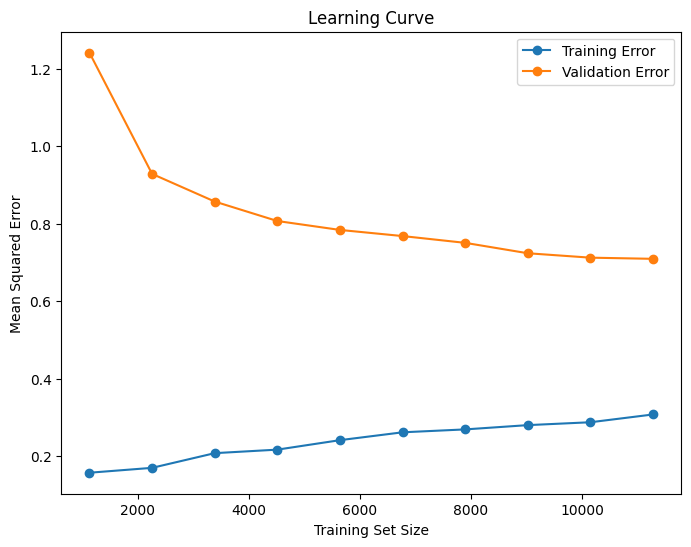

In [12]:
# learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# mean and standard deviation of scores
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Validation Error', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve')
plt.legend()
plt.show()


The learning curve illustrates that the training error is low and increases slightly as the training set size increases, which indicates that the model generalizes well and does not overfit the training data. On the other hand, The validation error starts high but decreases steadily as the training set size increases. The error plateaus after a certain point, indicating that additional data yields diminishing improvements.

There is a small but persistent gap between training and validation errors, showing slight overfitting. This gap remains relatively constant as the training set size increases, meaning that the model has reached its capacity for improvement.

### Model Evaluation

In [13]:
# Mean Squarred Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# R2 score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

# Adjusted R2 
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print(f"Adjusted R² Score: {r2}")

# RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Mean Absolute Percentage Error
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape}")

# Symmetric MAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)
print(f"Symmetric Mean Absolute Percentage Error: {smape}")



Mean Squared Error: 0.8146849729693569
R² Score: 0.9872499723016982
Adjusted R² Score: 0.9872499723016982
Root Mean Squared Error: 0.9025990100644676
Mean Absolute Error: 0.487142066466702
Mean Absolute Percentage Error: 0.8230877294252891
Symmetric Mean Absolute Percentage Error: 0.8223440532561315


The hyperparameter-tuned AdaBoost regressor demonstrates outstanding predictive performance, with minimal errors and near-perfect explanatory power. Compared to the baseline model (without tuning), the error metrics have significantly decreased, showcasing the effectiveness of the hyperparameter optimization process.



### Scatter Plot

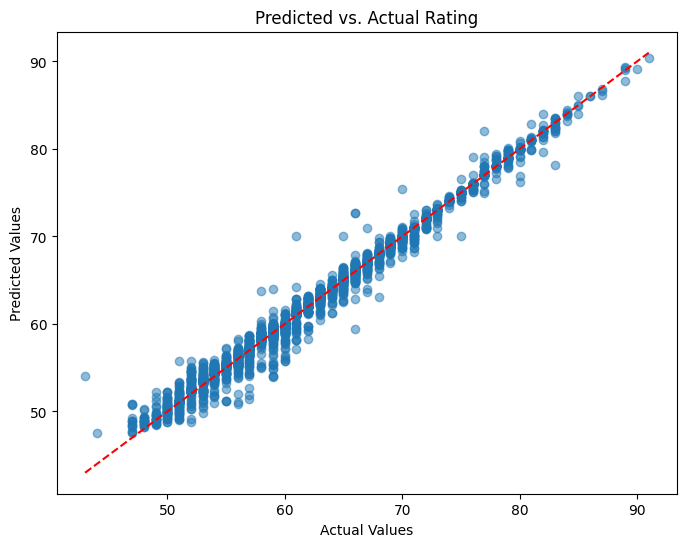

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Rating')
plt.show()

Compared to the untuned model, the spread of points around the diagonal is significantly reduced.
This suggests that hyperparameter tuning has improved the model's predictions across the entire range of actual values. The plot confirms the high R² Score (0.9872) and low error metrics (e.g., MAPE 0.823%) achieved after tuning.


### Residual Plot

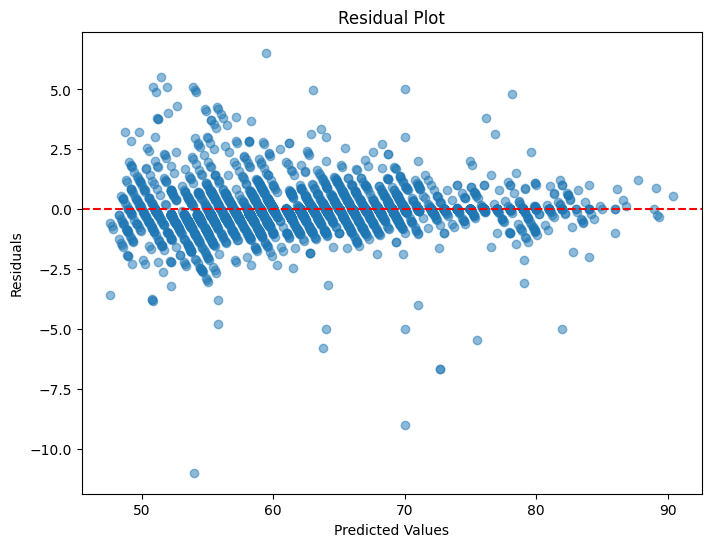

In [15]:
residuals_ = y_test - y_pred

# Plot 
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals_, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

The residuals have smaller magnitudes compared to the untuned model, aligning with improved error metrics. The residuals show a more uniform spread, suggesting the model has generalized better across the range of predictions.

### Distribution of Residuals

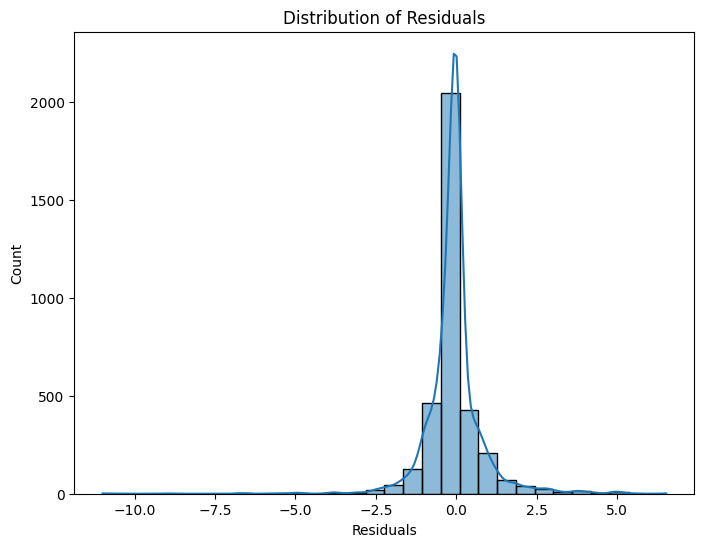

In [16]:

# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals_, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

The peak of the distribution is now more sharply centered at 0, indicating that most predictions are very close to the actual values. This reflects the significant reduction in prediction errors achieved through hyperparameter tuning. In addition, The residuals are tightly clustered around zero, with very few errors exceeding −2.5 or +2.5, confirming that the model has minimized large deviations.

### Q-Q Plot of Residuals

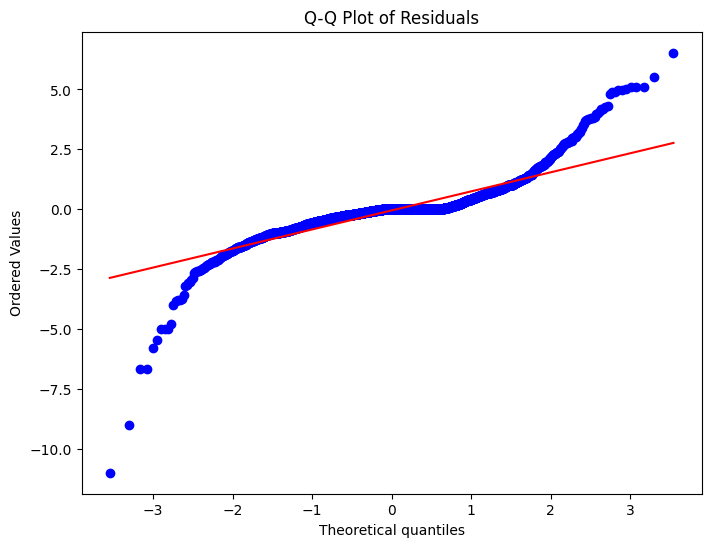

In [17]:
# Q-Q plot for residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals_, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

The residuals largely follow a normal distribution, as indicated by the close alignment with the diagonal line in the central region. However, the slight curvature in the Q-Q plot indicates minor departures from normality, particularly in the tails, but it is not severe. 

### Feature Selection

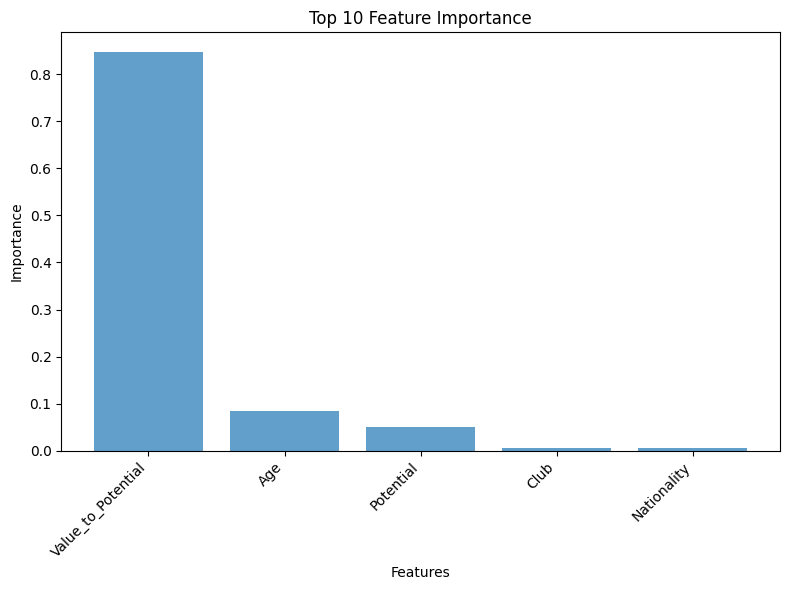

In [18]:
feature_importances = best_model.feature_importances_

# DataFrame for sorting
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_n = 5  # top 5 features to display
importance_df_top = importance_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.bar(importance_df_top['Feature'], importance_df_top['Importance'], alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

After identifying the features that contribute to our predictions the most, we will now train our model on these selected features


In [19]:
selected_features = importance_df['Feature'][:5].tolist()  # Top 5 features
print(f"Selected Features: {selected_features}")

Selected Features: ['Value_to_Potential', 'Age', 'Potential', 'Club', 'Nationality']


In [20]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Training a new AdaBoost model with the selected features
new_adaboost_regressor = AdaBoostRegressor(
    estimator=best_model.estimator,
    n_estimators=best_model.n_estimators,
    learning_rate=best_model.learning_rate,
    random_state=42
)
new_adaboost_regressor.fit(X_train_selected, y_train)

# Predictions on the test set using the model with selected features
y_pred_selected = new_adaboost_regressor.predict(X_test_selected)



### Model Evaluation

In [21]:
# Mean Squarred Error
mse = mean_squared_error(y_test, y_pred_selected)
print(f"Mean Squared Error: {mse}")

# R2 score
r2 = r2_score(y_test, y_pred_selected)
print(f"R² Score: {r2}")

# Adjusted R2 
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print(f"Adjusted R² Score: {r2}")

# RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_selected)
print(f"Mean Absolute Error: {mae}")

# Mean Absolute Percentage Error
mape = np.mean(np.abs((y_test - y_pred_selected) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape}")

# Symmetric MAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
smape = symmetric_mean_absolute_percentage_error(y_test, y_pred_selected)
print(f"Symmetric Mean Absolute Percentage Error: {smape}")



Mean Squared Error: 0.8675297874865441
R² Score: 0.9864229374708605
Adjusted R² Score: 0.9864229374708605
Root Mean Squared Error: 0.9314127911332032
Mean Absolute Error: 0.5315015938605779
Mean Absolute Percentage Error: 0.8979463639657416
Symmetric Mean Absolute Percentage Error: 0.896051875084568


The results do not show any significant improvements after traing our model with selected features

### Scatter Plot 

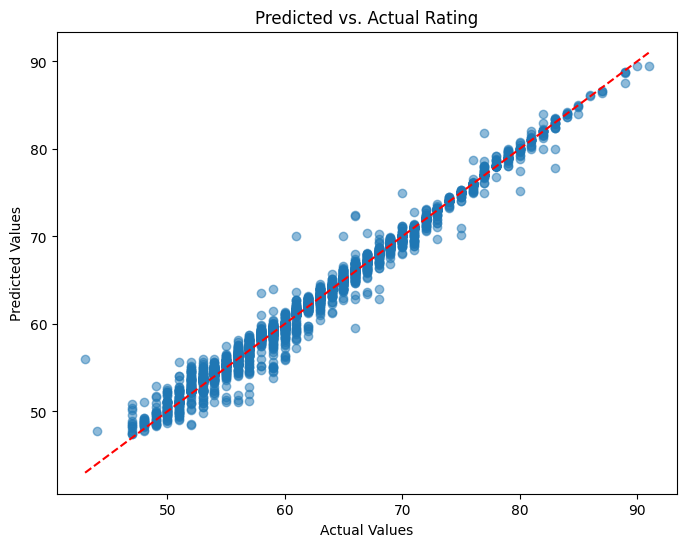

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_selected, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Rating')
plt.show()

### Residual Plot 

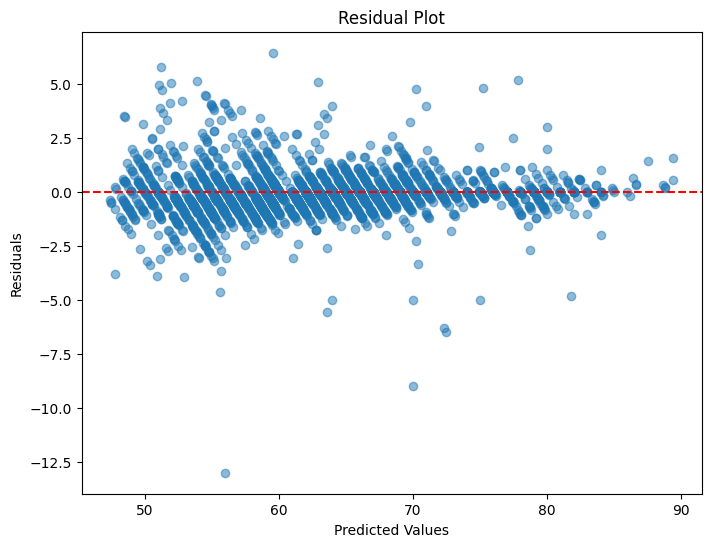

In [23]:
residuals_selected = y_test - y_pred_selected

# Plot 
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_selected, residuals_selected, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Distribution of Residuals 

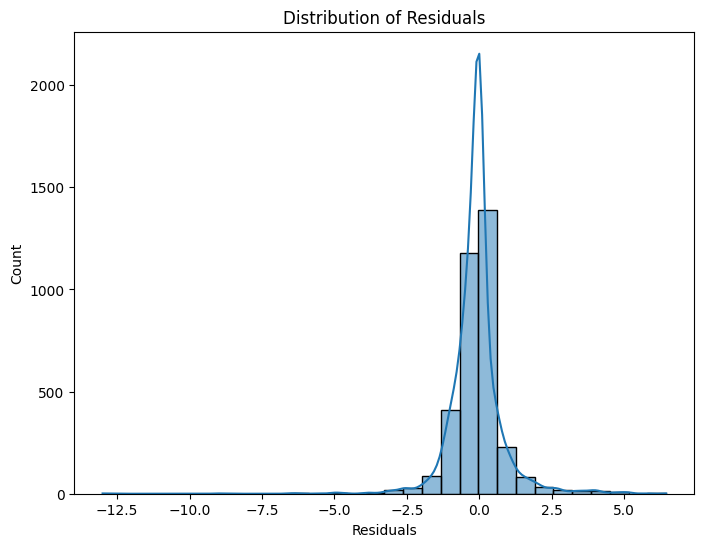

In [24]:
# Histogram of selected residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals_selected, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

### Q-Q Plot of Residuals 

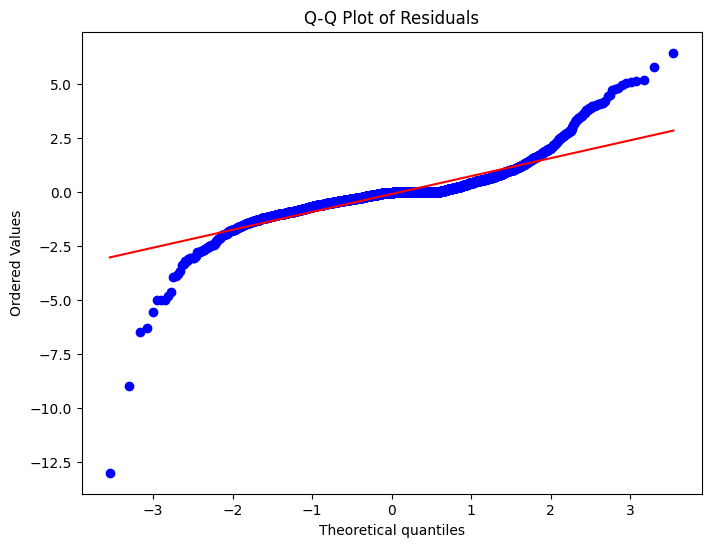

In [25]:
# Q-Q plot for selected residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals_selected, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Summary 

After hyperparameter tuning, the AdaBoost model demonstrated exceptional performance in predicting the target variable. The fine-tuning process resulted in a model that achieves a strong balance between precision and generalization, as evident from both numerical metrics and visual plots.

The model attained an R² score of 0.987, meaning it explains 98.7% of the variance in the target variable. The Mean Squared Error (MSE) of 0.8147 and Root Mean Squared Error (RMSE) of 0.903 reflect highly accurate predictions. On average, the model’s predictions deviate by only 0.487 from the actual values, as shown by the Mean Absolute Error (MAE). Furthermore, the Mean Absolute Percentage Error (MAPE) of 0.823% underscores the model's ability to predict with exceptional accuracy relative to the target values.

Despite strong overall performance, a small number of outliers remain, as evident in the residuals. However, these deviations are minimal and do not significantly affect the model's reliability. Feature selection did not improve performance, so the final model includes all features. A potential remedy to counter slight overfitting, as shown in the learning curve plot could be training an XGBoost model, which will be the next part of the current project.